In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import recall_score
import re
import shap
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from scipy.stats import mannwhitneyu
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [46]:
# We will find the important feature for a person that is  'L2' 

In [47]:
# ======= STEP1 =======  - Data Cleaning

In [48]:
df = pd.read_excel("vela_research.xlsx")

In [49]:
df = df[df['num_acquisitions'] < 1] # get rid of the L4, L5

df = df[df['ipo_experience'] == 0]


In [50]:
def replace_labels(lst):
    if isinstance(lst, list):  # Ensure the value is a list before processing
        return [re.sub(r'L2_\d+', 'L2', re.sub(r'L3_\d+', 'L3', x)) for x in lst]
    elif isinstance(lst, str):  # Handle cases where lists are stored as strings
        lst = eval(lst) if lst.startswith('[') and lst.endswith(']') else [lst]  # Convert string to list if needed
        return [re.sub(r'L2_\d+', 'L2', re.sub(r'L3_\d+', 'L3', x)) for x in lst]
    return lst  # Return unchanged if it's neither a list nor a string

# Apply function to replace values
df['l0l3_persona'] = df['l0l3_persona'].apply(replace_labels)


In [51]:
def replace_labels(lst):
    if isinstance(lst, list):  # Ensure the value is a list before processing
        cleaned_lst = [re.sub(r'L2_\d+', 'L2', re.sub(r'L3_\d+', 'L3', x)) for x in lst]
        return list(set(cleaned_lst))  # Remove duplicates and keep unique values
    elif isinstance(lst, str):  # Handle cases where lists are stored as strings
        lst = eval(lst) if lst.startswith('[') and lst.endswith(']') else [lst]  # Convert string to list if needed
        cleaned_lst = [re.sub(r'L2_\d+', 'L2', re.sub(r'L3_\d+', 'L3', x)) for x in lst]
        return list(set(cleaned_lst))  # Remove duplicates and keep unique values
    return lst  # Return unchanged if it's neither a list nor a string

# Apply function to replace values
df['l0l3_persona'] = df['l0l3_persona'].apply(replace_labels)

In [52]:
df['l0l3_persona'].value_counts()

l0l3_persona
[L2]            4161
[L3, L2]        1333
[L1]            1105
[L3]             764
[L0]             521
[L1, L2]         341
[L0, L2]          69
[L3, L1]          62
[L3, L1, L2]      12
[L3, L0]           1
Name: count, dtype: int64

In [53]:
def transform_persona(persona):
    if isinstance(persona, list) and 'L2' in persona and 'L3' not in persona:
        return ['L2']
    return persona  


df['l0l3_persona'] = df['l0l3_persona'].apply(transform_persona)


In [54]:
# here we use the max stuff - L0<L1<L2<L3

df['l0l3_persona'].value_counts()

l0l3_persona
[L2]            4571
[L3, L2]        1333
[L1]            1105
[L3]             764
[L0]             521
[L3, L1]          62
[L3, L1, L2]      12
[L3, L0]           1
Name: count, dtype: int64

In [55]:
l=['L2'] 

In [56]:
filtered_df = df[df['l0l3_persona'].apply(lambda x: x == l)]

df=filtered_df.copy() # the model only has the L2 


In [57]:
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()


numeric_columns = df.select_dtypes(include=['number']).columns


threshold = 0.2 * len(df) 

# keeps only those columns where the number of missing values is less than or equal to threshold
filtered_columns = [col for col in numeric_columns if df[col].isna().sum() <= threshold] 


df_filtered = df[filtered_columns]

df_filtered = df_filtered.dropna()
df_filtered.drop(columns=['org_total_funding_usd'], inplace=True)
filtered_columns = [col for col in filtered_columns if col != 'org_total_funding_usd']


In [58]:
# ======= STEP2 =======  - Find relevant features using SHAP values from Neural Networks and RandomForest 

In [59]:

# Define important columns
filtered_columns = [col for col in filtered_columns if col != 'success']

X = df_filtered[filtered_columns]
y = df_filtered[['success']]

# 80% - 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 75% - 25% ( overall 60% - 20% - 20 % )
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


y_train = np.array(y_train).ravel()


class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)


weights_dict = {0: class_weights[0], 1: class_weights[1]} # use this because the data is v imbalanced 




model = Sequential([
    Dense(128, kernel_regularizer=l1_l2(l1=1e-4, l2=1e-4), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),

    Dense(64, kernel_regularizer=l1_l2(l1=1e-4, l2=1e-4)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    
    Dense(32, kernel_regularizer=l1_l2(l1=1e-4, l2=1e-4)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),

    Dense(16, kernel_regularizer=l1_l2(l1=1e-4, l2=1e-4)),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])


model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)



history = model.fit(
    X_train, y_train,
    epochs=100, 
    batch_size=32,
    class_weight=weights_dict,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr], 
    verbose=1
)


y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.8).astype(int).flatten() # false positives are more costly


accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)


# false positives are more costly than missing out


Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6588 - loss: 0.9917 - val_accuracy: 0.6375 - val_loss: 0.8522 - learning_rate: 0.0010
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6594 - loss: 0.8736 - val_accuracy: 0.6566 - val_loss: 0.8451 - learning_rate: 0.0010
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6641 - loss: 0.7973 - val_accuracy: 0.6554 - val_loss: 0.8093 - learning_rate: 0.0010
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6799 - loss: 0.7524 - val_accuracy: 0.6566 - val_loss: 0.7897 - learning_rate: 0.0010
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6988 - loss: 0.7130 - val_accuracy: 0.6880 - val_loss: 0.7558 - learning_rate: 0.0010
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7056 - loss: 0.7382 - val_accuracy: 0.6891 - val_loss: 0.7503 - learning_rate: 0.0010
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6981 - loss: 0.7040 - val_accuracy: 0.701

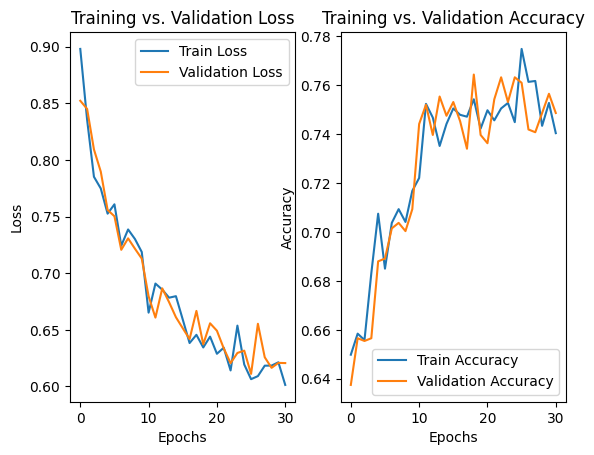

In [60]:
# Loss Curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')


# Accuracy Curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')

plt.show()

In [61]:


precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

Precision: 0.4359


In [62]:


# Compute TPR (Recall)
tpr = recall_score(y_test, y_pred)

print(f'TPR (Recall): {tpr:.4f}')


TPR (Recall): 0.2615


In [63]:


# Calculate AUC-ROC
auc = roc_auc_score(y_test, y_pred_probs)
print(f"AUC-ROC: {auc:.4f}")


AUC-ROC: 0.7533


In [64]:
# Find the SHAP values of this model

PermutationExplainer explainer: 893it [00:36, 17.81it/s]                        
/var/folders/qs/0tbv7f593t14wdc49rh246300000gn/T/ipykernel_58371/522712134.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)


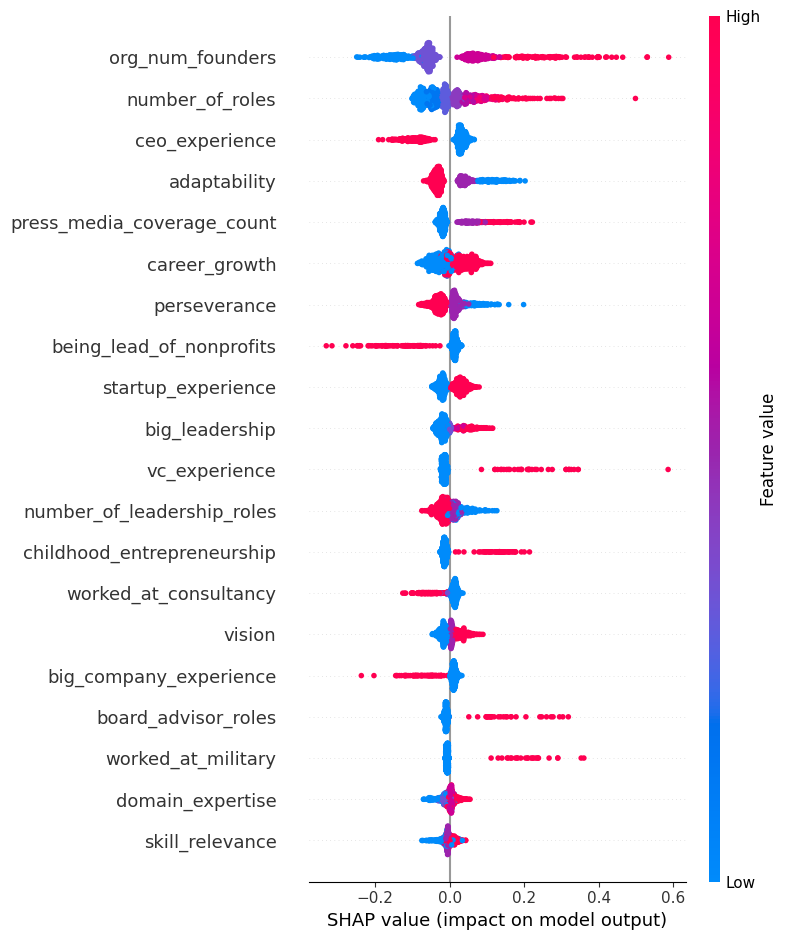

In [65]:


X_test_np = np.array(X_test)
feature_names = filtered_columns

explainer = shap.Explainer(model, X_test_np)
shap_values = explainer(X_test_np)

shap_values.feature_names = feature_names  


plt.figure(figsize=(6, 4)) 
shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
plt.show()

In [66]:
shap_df = pd.DataFrame(np.abs(shap_values.values).mean(axis=0), index=feature_names, columns=["SHAP Value"])
shap_df = shap_df.sort_values(by="SHAP Value", ascending=False)
top_20_features = shap_df.head(20) # select top 20 most influencial features 

In [67]:
top_features_1 = top_20_features.index.to_list()

In [68]:
# we present a general model of Random Forest Classifier 

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'class_weight': {0: 1, 1: 20}, 'max_depth': 10, 'n_estimators': 100}
Validation Accuracy: 0.8731762065095399
Test Accuracy: 0.8756
Confusion Matrix:
[[762  65]
 [ 46  19]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       827
           1       0.23      0.29      0.26        65

    accuracy                           0.88       892
   macro avg       0.58      0.61      0.59       892
weighted avg       0.89      0.88      0.88       892



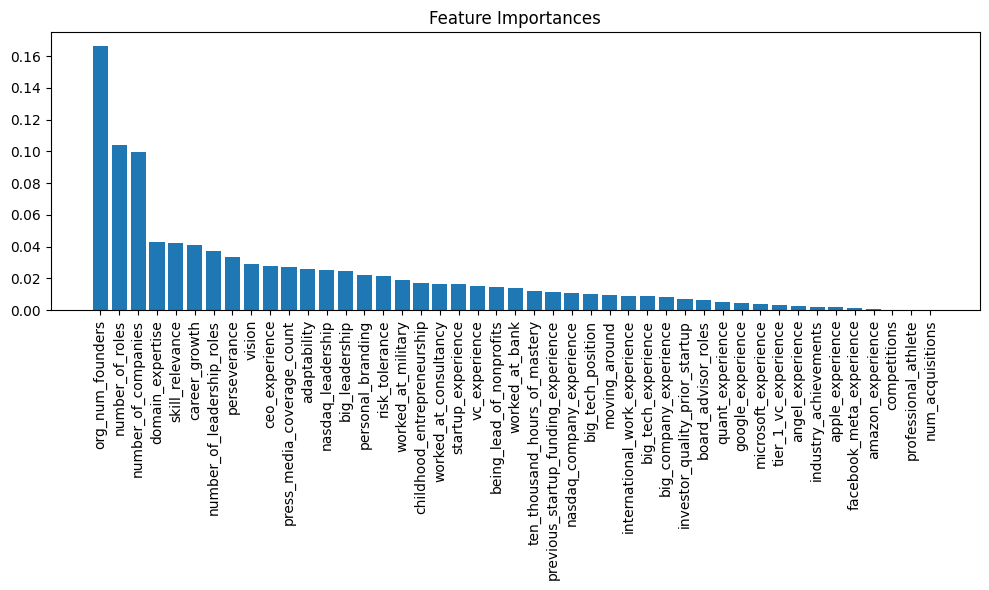

In [69]:


# Define important columns
filtered_columns = [col for col in filtered_columns if col != 'success']

X = df_filtered[filtered_columns]
y = df_filtered['success']

# 80% - 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 75% - 25% ( overall 60% - 20% - 20 % )
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'class_weight': [{0: 1, 1: w} for w in [5, 10, 20]]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           scoring='f1', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print('Best Parameters:', grid_search.best_params_)


best_rf_model = grid_search.best_estimator_


y_val_pred = best_rf_model.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val, y_val_pred))


y_pred = best_rf_model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Test Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

# Plot Feature Importance
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [filtered_columns[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

In [70]:
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort in descending order

# Get top 15 features and their importance values
top_20_features = pd.DataFrame({
    "Feature": [filtered_columns[i] for i in indices[:20]],
    "Importance": importances[indices[:20]]
})
top_features_2 = top_20_features['Feature'].to_list()

top_features_2

['org_num_founders',
 'number_of_roles',
 'number_of_companies',
 'domain_expertise',
 'skill_relevance',
 'career_growth',
 'number_of_leadership_roles',
 'perseverance',
 'vision',
 'ceo_experience',
 'press_media_coverage_count',
 'adaptability',
 'nasdaq_leadership',
 'big_leadership',
 'personal_branding',
 'risk_tolerance',
 'worked_at_military',
 'childhood_entrepreneurship',
 'worked_at_consultancy',
 'startup_experience']

In [71]:
# Random Forest focused on precision, here we change the grid_search parameter

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_

Best Parameters: {'class_weight': {0: 1, 1: 5}, 'max_depth': 10, 'n_estimators': 300}
Validation Accuracy: 0.9371492704826038
Validation Precision: 0.8
Test Accuracy: 0.9372
Confusion Matrix:
[[832   0]
 [ 56   4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       832
           1       1.00      0.07      0.12        60

    accuracy                           0.94       892
   macro avg       0.97      0.53      0.55       892
weighted avg       0.94      0.94      0.91       892



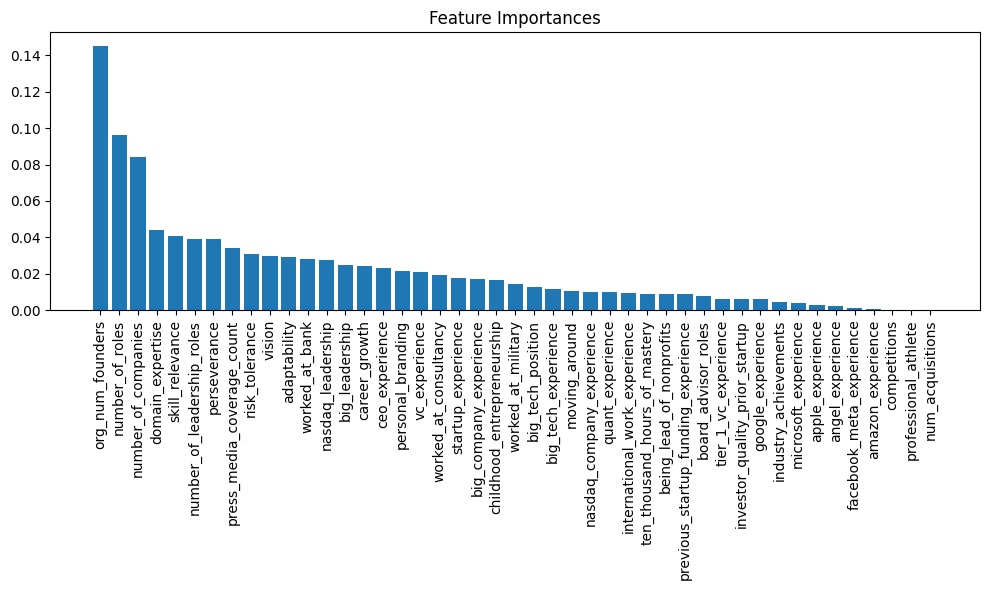

In [72]:



filtered_columns = [col for col in filtered_columns if col != 'success']

X = df_filtered[filtered_columns]
y = df_filtered['success']

# Same split as above 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'class_weight': [{0: 1, 1: w} for w in [5, 10, 20]]
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           scoring='precision', cv=5, verbose=2, n_jobs=-1) # we change here to 'precision'
grid_search.fit(X_train, y_train)
print('Best Parameters:', grid_search.best_params_)


best_rf_model = grid_search.best_estimator_


y_val_pred = best_rf_model.predict(X_val)
print('Validation Accuracy:', accuracy_score(y_val, y_val_pred))
print('Validation Precision:', precision_score(y_val, y_val_pred))


y_pred = best_rf_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Test Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [filtered_columns[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


In [73]:
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]  # sort in descending order

# top 20 features and their importance values
top_20_features = pd.DataFrame({
    "Feature": [filtered_columns[i] for i in indices[:20]],
    "Importance": importances[indices[:20]]
})

top_features_3 =  top_20_features['Feature'].to_list()

In [74]:
top_features_2_final =  list(set(top_features_2) & set(top_features_3)) 

top_features_2_final # the interesection between the feature importance of these 2 models

['nasdaq_leadership',
 'ceo_experience',
 'perseverance',
 'vision',
 'adaptability',
 'domain_expertise',
 'number_of_roles',
 'startup_experience',
 'personal_branding',
 'skill_relevance',
 'big_leadership',
 'number_of_leadership_roles',
 'org_num_founders',
 'career_growth',
 'number_of_companies',
 'risk_tolerance',
 'worked_at_consultancy',
 'press_media_coverage_count']

In [77]:
top_features = list(set(top_features_1) & set(top_features_2)) 

In [78]:
# ======= STEP3 =======  - Find how relevant this features are to our prediction

In [79]:
top_features

['worked_at_military',
 'perseverance',
 'adaptability',
 'domain_expertise',
 'number_of_roles',
 'startup_experience',
 'childhood_entrepreneurship',
 'skill_relevance',
 'big_leadership',
 'number_of_leadership_roles',
 'org_num_founders',
 'career_growth',
 'ceo_experience',
 'vision',
 'worked_at_consultancy',
 'press_media_coverage_count']

In [80]:
# Here we apply Man Whitney test for each column and separate the data in 2 sets: people with success and people that failed 

In [81]:
# Also we will print for each column the count for each value for when people succeed and when people failed 

In [82]:


count_ones = (df_filtered['success'] == 1).sum()

threshold = 15
final = []

if threshold * count_ones > len(df_filtered) and len(df_filtered) > 25:
    for col in top_features:
        
        print(f'The values for this {col} is (success) ' , df_filtered[df_filtered['success']==1][col].value_counts())
        print(f'The values for this {col} is (failure) ' , df_filtered[df_filtered['success']==0][col].value_counts())
        successful = df_filtered[df_filtered['success'] == 1][col]
        unsuccessful = df_filtered[df_filtered['success'] == 0][col]

        # Perform the Mann-Whitney U test
        if len(successful) > 0 and len(unsuccessful) > 0:
            stat, p_value = mannwhitneyu(successful, unsuccessful, alternative='two-sided')

            # Interpretation
            if p_value < 0.05:
                print(f"The distributions of '{col}' differ based on success. ✅")
                final.append(col)
            else:
                print(f"No significant difference in the distributions of '{col}'. ❌")
            print('\n')
        else:
            print(f"Not enough data to perform the test for '{col}'.")
else:
    print('Sorry, not enough data')


The values for this worked_at_military is (success)  worked_at_military
0.0    280
1.0     18
Name: count, dtype: int64
The values for this worked_at_military is (failure)  worked_at_military
0.0    4059
1.0      99
Name: count, dtype: int64
The distributions of 'worked_at_military' differ based on success. ✅


The values for this perseverance is (success)  perseverance
2.0    144
1.0    116
0.0     38
Name: count, dtype: int64
The values for this perseverance is (failure)  perseverance
2.0    2258
1.0    1448
0.0     452
Name: count, dtype: int64
The distributions of 'perseverance' differ based on success. ✅


The values for this adaptability is (success)  adaptability
2.0    180
1.0     88
0.0     30
Name: count, dtype: int64
The values for this adaptability is (failure)  adaptability
2.0    2659
1.0     975
0.0     524
Name: count, dtype: int64
No significant difference in the distributions of 'adaptability'. ❌


The values for this domain_expertise is (success)  domain_expertise
3.

In [83]:
final

['worked_at_military',
 'perseverance',
 'number_of_roles',
 'skill_relevance',
 'big_leadership',
 'org_num_founders',
 'career_growth',
 'ceo_experience',
 'press_media_coverage_count']

[CV] END class_weight={0: 1, 1: 5}, max_depth=None, n_estimators=200; total time=   0.4s
[CV] END class_weight={0: 1, 1: 5}, max_depth=None, n_estimators=300; total time=   1.1s
[CV] END class_weight={0: 1, 1: 5}, max_depth=10, n_estimators=300; total time=   1.0s
[CV] END class_weight={0: 1, 1: 5}, max_depth=20, n_estimators=300; total time=   1.9s
[CV] END class_weight={0: 1, 1: 10}, max_depth=None, n_estimators=200; total time=   0.9s
[CV] END class_weight={0: 1, 1: 10}, max_depth=10, n_estimators=100; total time=   0.2s
[CV] END class_weight={0: 1, 1: 10}, max_depth=10, n_estimators=200; total time=   0.8s
[CV] END class_weight={0: 1, 1: 10}, max_depth=10, n_estimators=300; total time=   1.3s
[CV] END class_weight={0: 1, 1: 10}, max_depth=20, n_estimators=300; total time=   1.0s
[CV] END class_weight={0: 1, 1: 20}, max_depth=None, n_estimators=200; total time=   0.5s
[CV] END class_weight={0: 1, 1: 20}, max_depth=10, n_estimators=100; total time=   0.2s
[CV] END class_weight={0: 1,